In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
path = os.getcwd()

def load_particles_bin(filename, n_particles):
    with open(filename, "rb") as f:
        data = np.fromfile(f, dtype=np.float64).reshape(n_particles, 7)
    return data

n_particles = int(1e5)
filename = path + "/particles_fmm/plummer_vel_3d_1e5_step0_var.bin"
particles = load_particles_bin(filename, n_particles)
x = particles[:, 1]
y = particles[:, 2]
z = particles[:, 3]
print("Loaded", n_particles, "particles.")

Loaded 100000 particles.


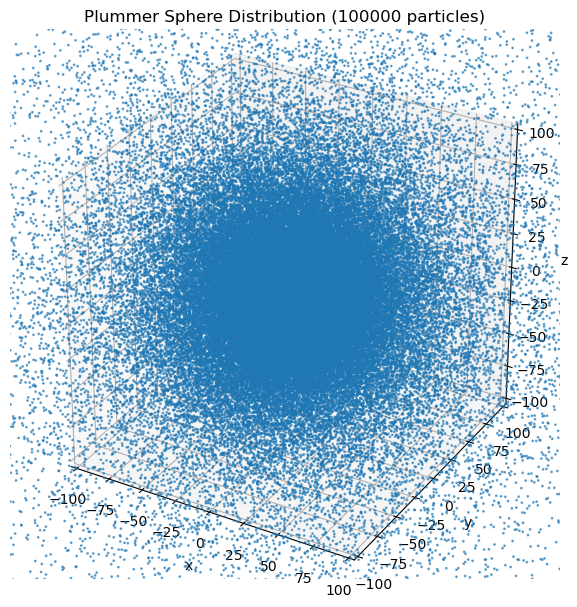

In [2]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, s=1, alpha=0.6)
ax.set_title("Plummer Sphere Distribution ({} particles)".format(n_particles))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_box_aspect([1,1,1])
bound = 100
ax.set_xbound(-bound, bound)
ax.set_ybound(-bound, bound)
ax.set_zbound(-bound, bound)
plt.tight_layout()

GIF 已儲存為 plummer_evolution.gif


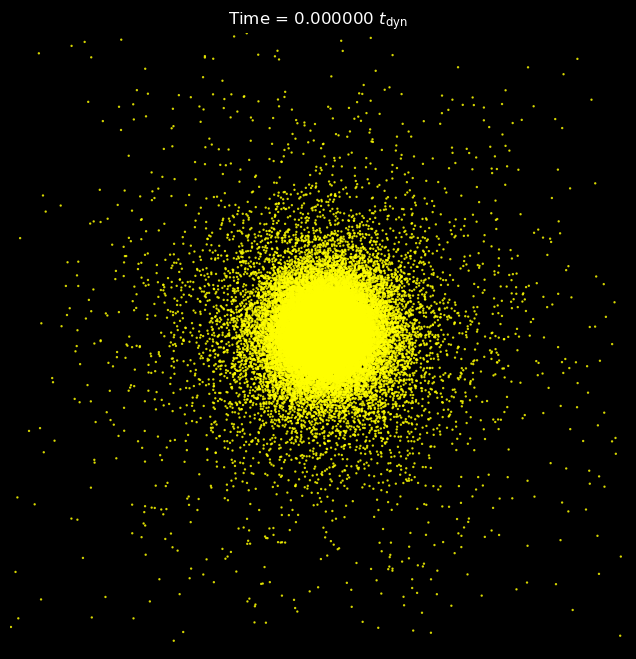

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import os

# 資料參數
n_particles = int(1e5)
n_steps = 200 + 1
data_dir = os.getcwd() + "/particles_fmm"
bound = 500

# 載入某一時間步的資料
def load_particles(step):
    filename = f"{data_dir}/plummer_vel_3d_1e5_step{step}_var.bin"
    data = np.fromfile(filename, dtype=np.float64).reshape(n_particles, 7)
    return data[:, 1], data[:, 2], data[:, 3]

# 圖表設定
fig = plt.figure(figsize=(8, 8), facecolor='black')
ax = fig.add_subplot(111, projection='3d', facecolor='black')

sc = ax.scatter([], [], [], s=0.5, color='yellow', alpha=0.8)

# 移除座標軸與標籤
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_axis_off()

# 設定邊界
ax.set_box_aspect([1, 1, 1])
ax.set_xlim(-bound, bound)
ax.set_ylim(-bound, bound)
ax.set_zlim(-bound, bound)

# 更新函數
def update(frame):
    x, y, z = load_particles(frame)
    sc._offsets3d = (x, y, z)
    time = frame*0.1/np.sqrt(1.25)
    ax.set_title(f"Time = {time:3.6f}"+" $t_\mathrm{dyn}$", color='white', fontsize=12)
    return sc,

# 建立動畫
ani = FuncAnimation(fig, update, frames=n_steps, interval=100, blit=False)

# 儲存 GIF
ani.save(f"plummer_evolution_bound{bound}_var.gif", writer="pillow", fps=20)

print("GIF 已儲存為 plummer_evolution.gif")


# $\rho(r)$ vs $r$

## FMM

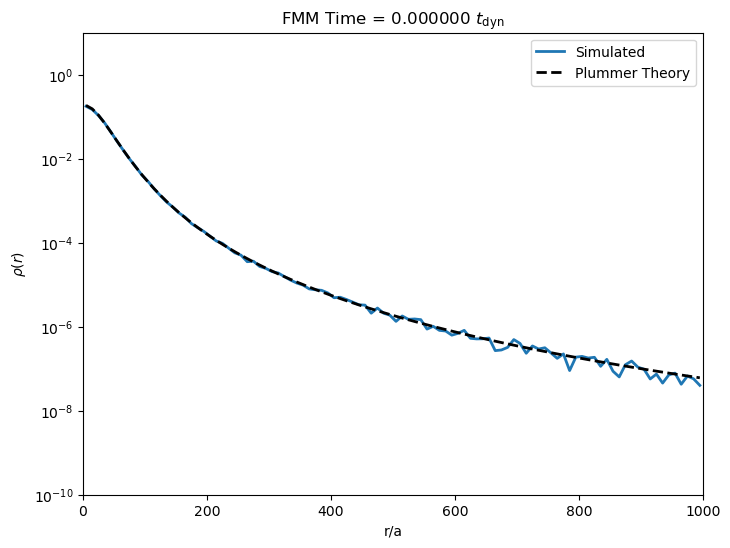

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os

# 模型參數
n_particles = int(1e5)
n_steps = 200 + 1
data_dir = os.getcwd() + "/particles_fmm"
M = 1.0*int(1e5)  # 總質量
a = 50.0  # Plummer 核心尺度
r_max = 1000
n_bins = 100
bin_edges = np.linspace(0, r_max, n_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
shell_volumes = 4/3 * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# 理論密度函數
def plummer_density(r, M=M, a=a):
    return (3 * M) / (4 * np.pi * a**3) * (1 + (r/a)**2) ** (-2.5)

rho_theory = plummer_density(bin_centers)

# 載入粒子半徑
def load_radii(step):
    filename = f"{data_dir}/plummer_vel_3d_1e5_step{step}_var.bin"
    data = np.fromfile(filename, dtype=np.float64).reshape(n_particles, 7)
    x, y, z = data[:, 1], data[:, 2], data[:, 3]
    r = np.sqrt(x**2 + y**2 + z**2)
    return r

# 設定圖形
fig, ax = plt.subplots(figsize=(8, 6))
line_sim, = ax.plot([], [], label="Simulated", lw=2)
line_theory, = ax.plot(bin_centers, rho_theory, 'k--', label="Plummer Theory", lw=2)
ax.set_xlim(0, r_max)
ax.set_ylim(1e-10, 10)
ax.set_yscale("log")
ax.set_xlabel("r/a")
ax.set_ylabel(r"$\rho(r)$")
ax.set_title("Density Profile Comparison")
ax.legend()

# 更新函數
def update(frame):
    r = load_radii(frame)
    counts, _ = np.histogram(r, bins=bin_edges)
    rho_sim = counts / shell_volumes
    line_sim.set_data(bin_centers, rho_sim)
    time = frame*0.1/np.sqrt(1.25)
    ax.set_title(f"FMM Time = {time:3.6f}"+" $t_\mathrm{dyn}$")
    return line_sim, line_theory

# 建立動畫
ani = FuncAnimation(fig, update, frames=n_steps, interval=100, blit=False)
ani.save("density_profile_comparison_fmm_var.gif", writer="pillow", fps=20)

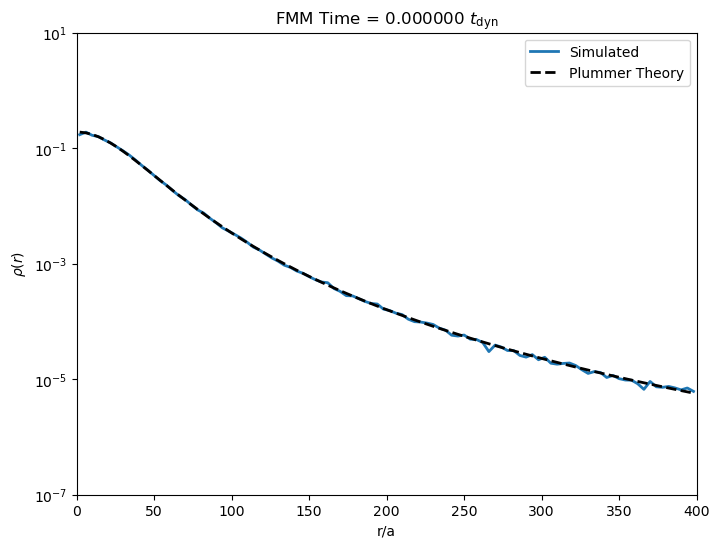

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os

# 模型參數
n_particles = int(1e5)
n_steps = 200 + 1
data_dir = os.getcwd() + "/particles_fmm"
M = 1.0*int(1e5)  # 總質量
a = 50.0  # Plummer 核心尺度
r_max = 400
n_bins = 100
bin_edges = np.linspace(0, r_max, n_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
shell_volumes = 4/3 * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# 理論密度函數
def plummer_density(r, M=M, a=a):
    return (3 * M) / (4 * np.pi * a**3) * (1 + (r/a)**2) ** (-2.5)

rho_theory = plummer_density(bin_centers)

# 載入粒子半徑
def load_radii(step):
    filename = f"{data_dir}/plummer_vel_3d_1e5_step{step}_var.bin"
    data = np.fromfile(filename, dtype=np.float64).reshape(n_particles, 7)
    x, y, z = data[:, 1], data[:, 2], data[:, 3]
    r = np.sqrt(x**2 + y**2 + z**2)
    return r

# 設定圖形
fig, ax = plt.subplots(figsize=(8, 6))
line_sim, = ax.plot([], [], label="Simulated", lw=2)
line_theory, = ax.plot(bin_centers, rho_theory, 'k--', label="Plummer Theory", lw=2)
ax.set_xlim(0, r_max)
ax.set_ylim(1e-7, 10)
ax.set_yscale("log")
ax.set_xlabel("r/a")
ax.set_ylabel(r"$\rho(r)$")
ax.set_title("Density Profile Comparison")
ax.legend()

# 更新函數
def update(frame):
    r = load_radii(frame)
    counts, _ = np.histogram(r, bins=bin_edges)
    rho_sim = counts / shell_volumes
    line_sim.set_data(bin_centers, rho_sim)
    time = frame*0.1/np.sqrt(1.25)
    ax.set_title(f"FMM Time = {time:3.6f}"+" $t_\mathrm{dyn}$")
    return line_sim, line_theory

# 建立動畫
ani = FuncAnimation(fig, update, frames=n_steps, interval=100, blit=False)
ani.save("density_profile_comparison_fmm_400_var.gif", writer="pillow", fps=20)

# Conserved quantity

## FMM

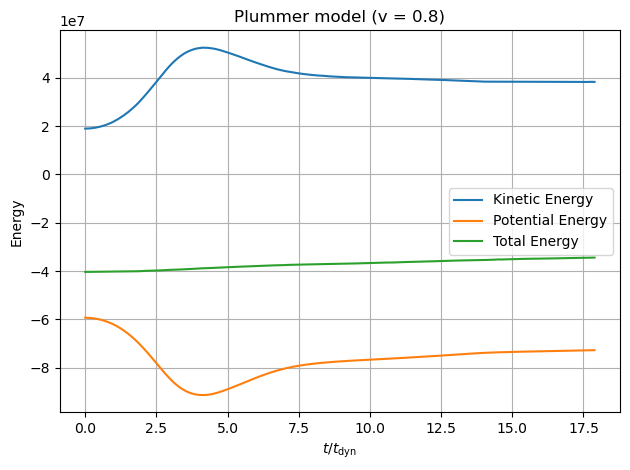

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
import pandas as pd

df = pd.read_csv("conservation/conservation_results_alpha1.25_fmm_var.csv")
time = df["i"]*0.1/np.sqrt(1.25)
f = df["K"] + df["U"]
plt.plot(time, df["K"], label="Kinetic Energy")
plt.plot(time, df["U"], label="Potential Energy")
plt.plot(time, df["U"]+df["K"], label="Total Energy")
drift = abs((f.iloc[0] - f.iloc[-1]) / f.iloc[0])
# plt.text(
#     0.1, 0.28,
#     f'Total energy drift error: {drift:.4f}',
#     transform=plt.gca().transAxes,
#     bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
# )
# plt.plot(time, 2 * df["K"]+df["U"], label="U+2K")
plt.xlabel('$t/t_\mathrm{dyn}$')
plt.ylabel('Energy')
plt.title('Plummer model (v = 0.8)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

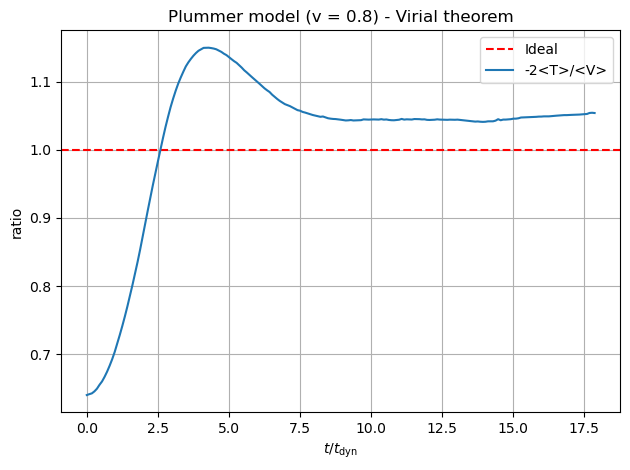

In [14]:
time = df["i"] * 0.1 / np.sqrt(1.25)
f = -2 * df["K"] / df["U"]

# 計算指標
drift = abs((f.iloc[0] - f.iloc[-1]) / f.iloc[0])
rms_error = np.sqrt(np.mean((f - 1) ** 2))

# 繪圖
plt.axhline(y=1, color='r', linestyle='--', label='Ideal')
plt.plot(time, f, label="-2<T>/<V>")
plt.xlabel('$t/t_\mathrm{dyn}$')
plt.ylabel('ratio')
plt.title('Plummer model (v = 0.8) - Virial theorem')
plt.legend()
plt.grid(True)

# 顯示誤差資訊
# plt.text(
#     0.025, 0.74,
#     f'drift error: {drift:.4f}\nRMS error: {rms_error:.4f}',
#     transform=plt.gca().transAxes,
#     bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
# )

plt.tight_layout()
plt.show()


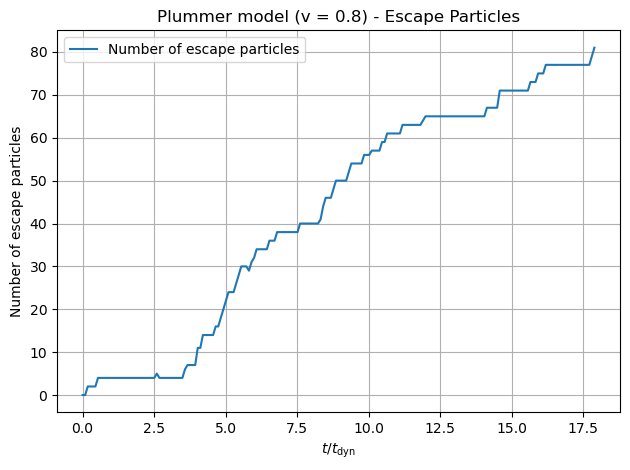

In [15]:
plt.title('Plummer model (v = 0.8) - Escape Particles')
time = df["i"]*0.1/np.sqrt(1.25)
plt.plot(time, df["Ne"], label="Number of escape particles")
plt.legend()
plt.xlabel('$t/t_\mathrm{dyn}$')
plt.ylabel('Number of escape particles')
plt.grid(True)
plt.tight_layout()
plt.show()

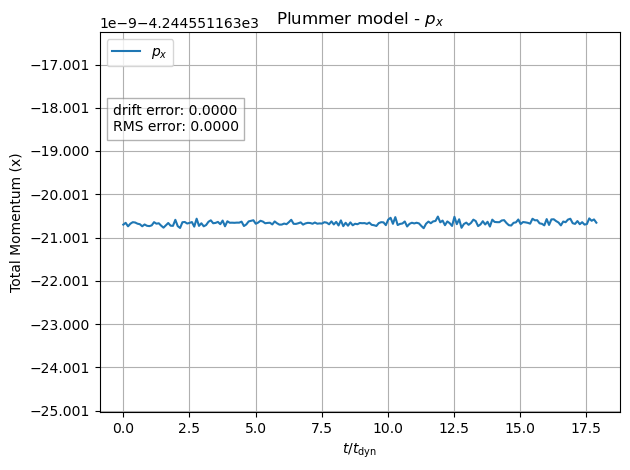

In [12]:
plt.title(r'Plummer model - $p_x$')
f = df["Px"]
time = df["i"]*0.1/np.sqrt(1.25)
drift = abs((f.iloc[0] - f.iloc[-1]) / f.iloc[0])
rms_error = np.sqrt(np.mean((f - f.iloc[0]) ** 2))

plt.plot(time, df["Px"], label=r"$p_x$")
plt.xlabel('$t/t_\mathrm{dyn}$')
plt.ylabel('Total Momentum (x)')
plt.text(
    0.025, 0.74,
    f'drift error: {drift:.4f}\nRMS error: {rms_error:.4f}',
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()